In [ ]:
import os
import gdown
from zipfile import ZipFile

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torchsummary import summary
import torchvision
from torchvision.utils import make_grid
from torchvision import datasets
from torchvision import transforms

import time
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# hyper parameters
BATCH_SIZE = 128
size = (64, 64)
dim_latent_vector = 100

In [ ]:
from torchvision.transforms.transforms import Normalize
transform = transforms.Compose([
    transforms.Resize(size=size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [ ]:
os.makedirs('celeba_gan')

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba_gan/data.zip"
gdown.download(url, output, quiet=True)



Access denied with the following error:



 	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684 



In [ ]:
with ZipFile(r'/content/drive/MyDrive/Colab_Notebooks/dataset/img_align_celeba.zip', "r") as zipobj:
    zipobj.extractall("celeba_gan")

In [ ]:
dataroot = '/content/celeba_gan'

dataset = datasets.ImageFolder(root=dataroot,
                           transform=transform)
print(len(dataset))

dataloader = data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


202599


In [ ]:
real_batch = next(iter(dataloader))
print(type(real_batch))
print(len(real_batch[0]))
print(np.shape(real_batch[0]))

<class 'list'>
128
torch.Size([128, 3, 64, 64])


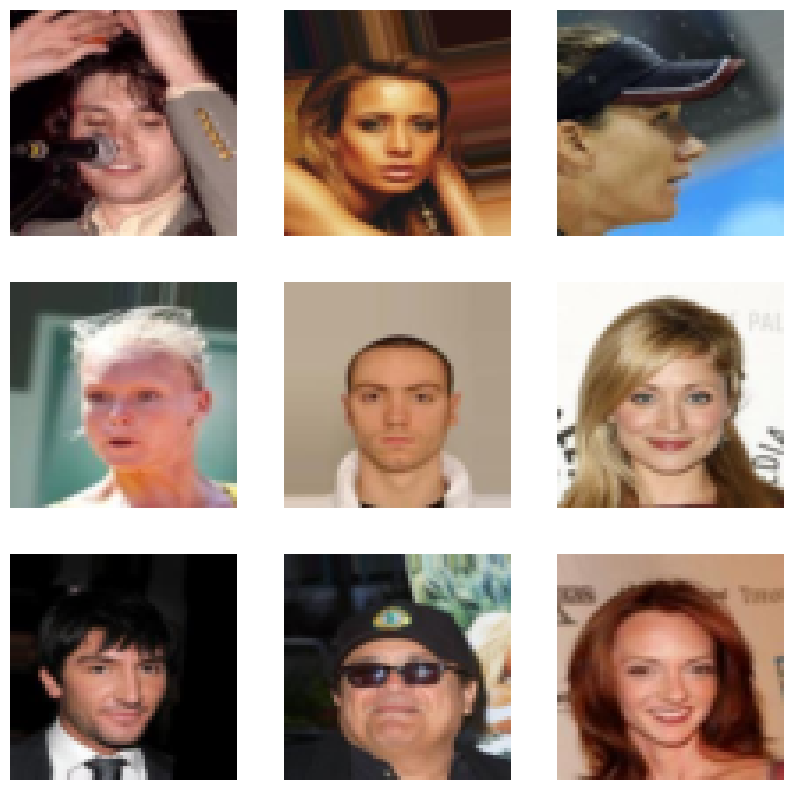

In [ ]:
plt.figure(figsize=(10,10))

for i in range(9):
    image = real_batch[0][i]
    # Making image (3, 64, 64) to (64, 64, 3)
    image = image.permute(1,2,0)
    # Making elements of arrays from [-1,1] to [0,1]
    image = (image+1)/2
    ax=plt.subplot(3,3,i+1)
    plt.imshow(image.numpy())
    plt.axis('off')

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(in_channels=100, out_channels=512, kernel_size=2, stride=1, padding=0, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=0, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.generator(x)
        return x

In [ ]:
generator = Generator()
generator = generator.to(device)
generator.apply(weights_init)
print(generator)

Generator(
  (generator): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(2, 2), stride=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): ReLU(inplace=True)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): ReLU(inplace=True)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): ReLU(inplace=True)
    

In [ ]:
summary(generator, input_size=(100, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 2, 2]         204,800
              ReLU-2            [-1, 512, 2, 2]               0
       BatchNorm2d-3            [-1, 512, 2, 2]           1,024
   ConvTranspose2d-4            [-1, 256, 4, 4]       1,179,648
              ReLU-5            [-1, 256, 4, 4]               0
       BatchNorm2d-6            [-1, 256, 4, 4]             512
   ConvTranspose2d-7            [-1, 128, 8, 8]         524,288
              ReLU-8            [-1, 128, 8, 8]               0
       BatchNorm2d-9            [-1, 128, 8, 8]             256
  ConvTranspose2d-10           [-1, 64, 16, 16]         131,072
             ReLU-11           [-1, 64, 16, 16]               0
      BatchNorm2d-12           [-1, 64, 16, 16]             128
  ConvTranspose2d-13           [-1, 32, 32, 32]          32,768
             ReLU-14           [-1, 32,

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=1,kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.discriminator(x)
        return x

In [ ]:
discriminator = Discriminator()
discriminator = discriminator.to(device)
discriminator.apply(weights_init)
print(discriminator)

Discriminator(
  (discriminator): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(256, 1, kernel_

In [ ]:
summary(discriminator, input_size=(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           1,536
         LeakyReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 64, 16, 16]          32,768
         LeakyReLU-5           [-1, 64, 16, 16]               0
       BatchNorm2d-6           [-1, 64, 16, 16]             128
            Conv2d-7            [-1, 128, 8, 8]         131,072
         LeakyReLU-8            [-1, 128, 8, 8]               0
       BatchNorm2d-9            [-1, 128, 8, 8]             256
           Conv2d-10            [-1, 256, 4, 4]         524,288
        LeakyReLU-11            [-1, 256, 4, 4]               0
      BatchNorm2d-12            [-1, 256, 4, 4]             512
           Conv2d-13              [-1, 1, 1, 1]           4,096
          Sigmoid-14              [-1, 

In [ ]:
criterion = nn.BCELoss()

fixed_noises = torch.randn(BATCH_SIZE, dim_latent_vector, 1, 1, device=device)

real_label = 1
fake_label = 0

d_optimizer = optim.Adam(discriminator.parameters(),lr = 0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(),lr = 0.0002, betas=(0.5, 0.999))

In [ ]:
# Training Loop

num_epochs = 10

img_list = []
G_losses = []
D_losses = []
iters = 0

since = time.time()
print('Starting Training Loop...')
for epoch in range(num_epochs):
    for i, data in enumerate(tqdm(dataloader), 0):
        # Update Discriminator: maximize log(D(x))+log(l-D(G(z)))
        # Train with all real batch
        discriminator.zero_grad()
        real_images = data[0].to(device)
        batch_size = real_images.size(0)
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        real_output = discriminator(real_images).view(-1)
        d_loss_real = criterion(real_output, label)
        d_loss_real.backward()
        D_x = d_loss_real.mean().item()

        # Train with all fake batch
        noise = torch.randn(batch_size, dim_latent_vector, 1, 1, device=device)
        generated_images = generator(noise)
        label.fill_(fake_label)
        fake_output = discriminator(generated_images.detach()).view(-1)
        d_loss_fake = criterion(fake_output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        d_loss_fake.backward()
        D_G_z1 = fake_output.mean().item()
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.step()

        # Update generator: maximize log(D(G(z)))
        generator.zero_grad()
        label.fill_(real_label)
        g_output = discriminator(generated_images).view(-1)
        g_loss = criterion(g_output, label)
        g_loss.backward()
        D_G_z2 = g_output.mean().item()
        g_optimizer.step()

        if i % 50 == 0:
            print(f'[{epoch}/{num_epochs}] [{i}/{len(dataloader)}]\tLoss_D:{d_loss.item():.4}\tLoss_G: {g_loss.item():.4}\tD(x):{D_x:.4}\tD(G(z)):{D_G_z1:.4}/{D_G_z2:.4}')

        # Save losses for plotting later
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                generated_imgs = generator(noise).detach().cpu()
            img_list.append(make_grid(generated_imgs, padding=2, normalize=True))

        iters += 1

time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed/60:.0f}m {time_elapsed%60:.0f}s')



Starting Training Loop...


  0%|          | 0/1583 [00:00<?, ?it/s]

[0/10] [0/1583]	Loss_D:1.785	Loss_G: 1.844	D(x):0.9802	D(G(z)):0.4787/0.2145
[0/10] [50/1583]	Loss_D:0.0815	Loss_G: 7.115	D(x):0.02521	D(G(z)):0.04956/0.002286
[0/10] [100/1583]	Loss_D:0.02927	Loss_G: 10.6	D(x):0.003217	D(G(z)):0.02432/0.0001458
[0/10] [150/1583]	Loss_D:0.002281	Loss_G: 13.65	D(x):0.001214	D(G(z)):0.001063/7.367e-06
[0/10] [200/1583]	Loss_D:0.02653	Loss_G: 7.47	D(x):0.001693	D(G(z)):0.02359/0.001865
[0/10] [250/1583]	Loss_D:0.04362	Loss_G: 7.729	D(x):0.002412	D(G(z)):0.03847/0.001405
[0/10] [300/1583]	Loss_D:0.0378	Loss_G: 7.209	D(x):0.01372	D(G(z)):0.02342/0.00222
[0/10] [350/1583]	Loss_D:0.04069	Loss_G: 5.909	D(x):0.004242	D(G(z)):0.03503/0.004247
[0/10] [400/1583]	Loss_D:0.08656	Loss_G: 6.987	D(x):0.004751	D(G(z)):0.07645/0.004951
[0/10] [450/1583]	Loss_D:0.03652	Loss_G: 6.167	D(x):0.00794	D(G(z)):0.02782/0.00292
[0/10] [500/1583]	Loss_D:1.899	Loss_G: 24.53	D(x):0.6626	D(G(z)):0.2981/2.151e-07
[0/10] [550/1583]	Loss_D:0.03078	Loss_G: 4.881	D(x):0.002548	D(G(z)):0.02

  0%|          | 0/1583 [00:00<?, ?it/s]

[1/10] [0/1583]	Loss_D:0.9479	Loss_G: 5.108	D(x):0.0938	D(G(z)):0.5069/0.01226
[1/10] [50/1583]	Loss_D:0.5452	Loss_G: 4.59	D(x):0.1132	D(G(z)):0.3138/0.0209
[1/10] [100/1583]	Loss_D:1.512	Loss_G: 6.541	D(x):0.0461	D(G(z)):0.7114/0.003337
[1/10] [150/1583]	Loss_D:0.6913	Loss_G: 3.509	D(x):0.2523	D(G(z)):0.3207/0.04471
[1/10] [200/1583]	Loss_D:0.6341	Loss_G: 3.066	D(x):0.3406	D(G(z)):0.2284/0.08066
[1/10] [250/1583]	Loss_D:0.5535	Loss_G: 3.513	D(x):0.2011	D(G(z)):0.2726/0.04652
[1/10] [300/1583]	Loss_D:1.15	Loss_G: 1.702	D(x):1.099	D(G(z)):0.04826/0.2426
[1/10] [350/1583]	Loss_D:0.7879	Loss_G: 2.635	D(x):0.5446	D(G(z)):0.1902/0.1171
[1/10] [400/1583]	Loss_D:0.5894	Loss_G: 2.818	D(x):0.3366	D(G(z)):0.1991/0.08749
[1/10] [450/1583]	Loss_D:0.5392	Loss_G: 3.091	D(x):0.2518	D(G(z)):0.2292/0.06975
[1/10] [500/1583]	Loss_D:0.7784	Loss_G: 3.225	D(x):0.2846	D(G(z)):0.3393/0.07237
[1/10] [550/1583]	Loss_D:0.9045	Loss_G: 2.184	D(x):0.6688	D(G(z)):0.1936/0.1649
[1/10] [600/1583]	Loss_D:0.6729	Loss_G

  0%|          | 0/1583 [00:00<?, ?it/s]

[2/10] [0/1583]	Loss_D:0.6339	Loss_G: 2.938	D(x):0.2897	D(G(z)):0.2609/0.08526
[2/10] [50/1583]	Loss_D:1.463	Loss_G: 5.166	D(x):0.1179	D(G(z)):0.673/0.01232
[2/10] [100/1583]	Loss_D:0.648	Loss_G: 2.153	D(x):0.3566	D(G(z)):0.2319/0.1474
[2/10] [150/1583]	Loss_D:0.8178	Loss_G: 3.238	D(x):0.2537	D(G(z)):0.3795/0.06318
[2/10] [200/1583]	Loss_D:0.7845	Loss_G: 3.009	D(x):0.3136	D(G(z)):0.3393/0.07816
[2/10] [250/1583]	Loss_D:1.579	Loss_G: 1.475	D(x):1.553	D(G(z)):0.0249/0.3324
[2/10] [300/1583]	Loss_D:0.701	Loss_G: 2.029	D(x):0.4266	D(G(z)):0.2231/0.1688
[2/10] [350/1583]	Loss_D:0.7723	Loss_G: 2.115	D(x):0.5989	D(G(z)):0.1441/0.1692
[2/10] [400/1583]	Loss_D:0.8699	Loss_G: 3.56	D(x):0.1852	D(G(z)):0.4439/0.04293
[2/10] [450/1583]	Loss_D:1.146	Loss_G: 1.55	D(x):1.084	D(G(z)):0.05763/0.2896
[2/10] [500/1583]	Loss_D:0.8036	Loss_G: 1.01	D(x):0.6378	D(G(z)):0.1413/0.4359
[2/10] [550/1583]	Loss_D:0.6486	Loss_G: 2.488	D(x):0.5055	D(G(z)):0.1195/0.1315
[2/10] [600/1583]	Loss_D:0.9454	Loss_G: 2.739	D(

  0%|          | 0/1583 [00:00<?, ?it/s]

[3/10] [0/1583]	Loss_D:0.725	Loss_G: 2.419	D(x):0.3928	D(G(z)):0.262/0.117
[3/10] [50/1583]	Loss_D:1.082	Loss_G: 1.545	D(x):0.955	D(G(z)):0.109/0.2733
[3/10] [100/1583]	Loss_D:0.5838	Loss_G: 2.913	D(x):0.3079	D(G(z)):0.2159/0.08567
[3/10] [150/1583]	Loss_D:0.8851	Loss_G: 1.921	D(x):0.4687	D(G(z)):0.3037/0.1963
[3/10] [200/1583]	Loss_D:1.188	Loss_G: 3.874	D(x):0.1594	D(G(z)):0.5865/0.02946
[3/10] [250/1583]	Loss_D:0.7149	Loss_G: 2.499	D(x):0.2215	D(G(z)):0.3559/0.1139
[3/10] [300/1583]	Loss_D:1.074	Loss_G: 1.208	D(x):1.003	D(G(z)):0.06465/0.3812
[3/10] [350/1583]	Loss_D:0.5273	Loss_G: 2.143	D(x):0.258	D(G(z)):0.224/0.1436
[3/10] [400/1583]	Loss_D:1.301	Loss_G: 1.017	D(x):1.246	D(G(z)):0.0512/0.426
[3/10] [450/1583]	Loss_D:0.87	Loss_G: 2.276	D(x):0.341	D(G(z)):0.3465/0.1554
[3/10] [500/1583]	Loss_D:0.7623	Loss_G: 3.11	D(x):0.2521	D(G(z)):0.3608/0.06552
[3/10] [550/1583]	Loss_D:0.9222	Loss_G: 1.47	D(x):0.7647	D(G(z)):0.139/0.2805
[3/10] [600/1583]	Loss_D:0.7139	Loss_G: 1.539	D(x):0.5511	D

  0%|          | 0/1583 [00:00<?, ?it/s]

[4/10] [0/1583]	Loss_D:0.6263	Loss_G: 2.094	D(x):0.3652	D(G(z)):0.2102/0.1671
[4/10] [50/1583]	Loss_D:0.6545	Loss_G: 2.899	D(x):0.2045	D(G(z)):0.3186/0.0824
[4/10] [100/1583]	Loss_D:0.6026	Loss_G: 2.633	D(x):0.3467	D(G(z)):0.2069/0.1008
[4/10] [150/1583]	Loss_D:0.7896	Loss_G: 1.699	D(x):0.5645	D(G(z)):0.1847/0.2426
[4/10] [200/1583]	Loss_D:0.7093	Loss_G: 1.485	D(x):0.4721	D(G(z)):0.2001/0.2722
[4/10] [250/1583]	Loss_D:0.7765	Loss_G: 1.745	D(x):0.645	D(G(z)):0.1152/0.2317
[4/10] [300/1583]	Loss_D:0.6233	Loss_G: 3.113	D(x):0.1793	D(G(z)):0.3309/0.0617
[4/10] [350/1583]	Loss_D:0.6111	Loss_G: 2.393	D(x):0.3026	D(G(z)):0.2443/0.1264
[4/10] [400/1583]	Loss_D:0.7706	Loss_G: 3.077	D(x):0.214	D(G(z)):0.3884/0.06658
[4/10] [450/1583]	Loss_D:0.6138	Loss_G: 2.723	D(x):0.1277	D(G(z)):0.3458/0.08829
[4/10] [500/1583]	Loss_D:0.9677	Loss_G: 2.819	D(x):0.3049	D(G(z)):0.4449/0.07905
[4/10] [550/1583]	Loss_D:0.5499	Loss_G: 3.301	D(x):0.1602	D(G(z)):0.3003/0.05229
[4/10] [600/1583]	Loss_D:0.5379	Loss_G: 1

  0%|          | 0/1583 [00:00<?, ?it/s]

[5/10] [0/1583]	Loss_D:1.016	Loss_G: 0.9127	D(x):0.9742	D(G(z)):0.04017/0.4563
[5/10] [50/1583]	Loss_D:0.769	Loss_G: 1.163	D(x):0.6728	D(G(z)):0.08496/0.3731
[5/10] [100/1583]	Loss_D:0.6877	Loss_G: 2.39	D(x):0.3382	D(G(z)):0.2654/0.1254
[5/10] [150/1583]	Loss_D:0.5224	Loss_G: 3.312	D(x):0.1949	D(G(z)):0.2547/0.05799
[5/10] [200/1583]	Loss_D:0.6039	Loss_G: 2.988	D(x):0.3735	D(G(z)):0.1866/0.07177
[5/10] [250/1583]	Loss_D:0.8339	Loss_G: 1.204	D(x):0.7543	D(G(z)):0.07415/0.3537
[5/10] [300/1583]	Loss_D:0.7035	Loss_G: 3.653	D(x):0.1291	D(G(z)):0.3944/0.03745
[5/10] [350/1583]	Loss_D:0.5541	Loss_G: 1.837	D(x):0.4168	D(G(z)):0.1204/0.2101
[5/10] [400/1583]	Loss_D:0.5084	Loss_G: 2.597	D(x):0.1619	D(G(z)):0.2702/0.09584
[5/10] [450/1583]	Loss_D:0.4883	Loss_G: 2.601	D(x):0.2239	D(G(z)):0.2126/0.1014
[5/10] [500/1583]	Loss_D:0.8802	Loss_G: 1.929	D(x):0.8348	D(G(z)):0.04324/0.195
[5/10] [550/1583]	Loss_D:0.503	Loss_G: 2.348	D(x):0.2649	D(G(z)):0.1912/0.1345
[5/10] [600/1583]	Loss_D:0.4868	Loss_G:

  0%|          | 0/1583 [00:00<?, ?it/s]

[6/10] [0/1583]	Loss_D:0.4453	Loss_G: 2.728	D(x):0.1892	D(G(z)):0.2132/0.08625
[6/10] [50/1583]	Loss_D:0.3728	Loss_G: 2.503	D(x):0.1802	D(G(z)):0.1662/0.1074
[6/10] [100/1583]	Loss_D:0.7751	Loss_G: 3.615	D(x):0.1785	D(G(z)):0.4173/0.03805
[6/10] [150/1583]	Loss_D:0.4559	Loss_G: 3.168	D(x):0.2106	D(G(z)):0.1995/0.06586
[6/10] [200/1583]	Loss_D:1.435	Loss_G: 4.67	D(x):0.09507	D(G(z)):0.6573/0.01697
[6/10] [250/1583]	Loss_D:1.386	Loss_G: 0.7672	D(x):1.32	D(G(z)):0.06175/0.5248
[6/10] [300/1583]	Loss_D:0.9019	Loss_G: 3.148	D(x):0.241	D(G(z)):0.4403/0.0622
[6/10] [350/1583]	Loss_D:1.904	Loss_G: 0.457	D(x):1.807	D(G(z)):0.08237/0.6811
[6/10] [400/1583]	Loss_D:1.15	Loss_G: 5.132	D(x):0.06691	D(G(z)):0.6184/0.01096
[6/10] [450/1583]	Loss_D:0.7887	Loss_G: 2.249	D(x):0.192	D(G(z)):0.3994/0.1459
[6/10] [500/1583]	Loss_D:0.6008	Loss_G: 2.349	D(x):0.3922	D(G(z)):0.1723/0.1273
[6/10] [550/1583]	Loss_D:0.7089	Loss_G: 3.371	D(x):0.1818	D(G(z)):0.3692/0.04625
[6/10] [600/1583]	Loss_D:0.8988	Loss_G: 4.3

  0%|          | 0/1583 [00:00<?, ?it/s]

[7/10] [0/1583]	Loss_D:0.7249	Loss_G: 1.171	D(x):0.6422	D(G(z)):0.0759/0.3684
[7/10] [50/1583]	Loss_D:0.5205	Loss_G: 2.302	D(x):0.2798	D(G(z)):0.192/0.1399
[7/10] [100/1583]	Loss_D:0.344	Loss_G: 2.43	D(x):0.2139	D(G(z)):0.1158/0.116
[7/10] [150/1583]	Loss_D:1.777	Loss_G: 4.747	D(x):0.05392	D(G(z)):0.7546/0.02009
[7/10] [200/1583]	Loss_D:0.506	Loss_G: 2.609	D(x):0.3124	D(G(z)):0.1646/0.09824
[7/10] [250/1583]	Loss_D:0.5523	Loss_G: 2.98	D(x):0.3037	D(G(z)):0.1997/0.07371
[7/10] [300/1583]	Loss_D:0.9704	Loss_G: 4.463	D(x):0.08331	D(G(z)):0.521/0.02316
[7/10] [350/1583]	Loss_D:0.7119	Loss_G: 2.115	D(x):0.4994	D(G(z)):0.1755/0.1585
[7/10] [400/1583]	Loss_D:1.207	Loss_G: 4.892	D(x):0.02788	D(G(z)):0.64/0.01309
[7/10] [450/1583]	Loss_D:0.3381	Loss_G: 3.984	D(x):0.1021	D(G(z)):0.1921/0.03231
[7/10] [500/1583]	Loss_D:0.4603	Loss_G: 2.164	D(x):0.2617	D(G(z)):0.1714/0.1472
[7/10] [550/1583]	Loss_D:0.4192	Loss_G: 3.528	D(x):0.1005	D(G(z)):0.254/0.04097
[7/10] [600/1583]	Loss_D:0.4408	Loss_G: 2.529

  0%|          | 0/1583 [00:00<?, ?it/s]

[8/10] [0/1583]	Loss_D:0.5439	Loss_G: 4.018	D(x):0.07779	D(G(z)):0.3401/0.02851
[8/10] [50/1583]	Loss_D:0.3153	Loss_G: 3.394	D(x):0.1667	D(G(z)):0.1301/0.04892
[8/10] [100/1583]	Loss_D:1.666	Loss_G: 3.258	D(x):0.1497	D(G(z)):0.7009/0.06957
[8/10] [150/1583]	Loss_D:0.6225	Loss_G: 1.932	D(x):0.392	D(G(z)):0.1858/0.2057
[8/10] [200/1583]	Loss_D:0.3937	Loss_G: 2.775	D(x):0.2505	D(G(z)):0.1251/0.08925
[8/10] [250/1583]	Loss_D:0.5357	Loss_G: 2.553	D(x):0.4021	D(G(z)):0.1171/0.121
[8/10] [300/1583]	Loss_D:0.2695	Loss_G: 3.655	D(x):0.1585	D(G(z)):0.09252/0.04129
[8/10] [350/1583]	Loss_D:0.8542	Loss_G: 4.915	D(x):0.06584	D(G(z)):0.5011/0.01106
[8/10] [400/1583]	Loss_D:0.3663	Loss_G: 2.871	D(x):0.08689	D(G(z)):0.2088/0.09074
[8/10] [450/1583]	Loss_D:0.6996	Loss_G: 1.706	D(x):0.6291	D(G(z)):0.06317/0.2556
[8/10] [500/1583]	Loss_D:0.333	Loss_G: 3.163	D(x):0.07217	D(G(z)):0.209/0.06227
[8/10] [550/1583]	Loss_D:0.4113	Loss_G: 4.428	D(x):0.09175	D(G(z)):0.2519/0.0198
[8/10] [600/1583]	Loss_D:0.4725	L

  0%|          | 0/1583 [00:00<?, ?it/s]

[9/10] [0/1583]	Loss_D:0.7459	Loss_G: 1.457	D(x):0.7007	D(G(z)):0.04269/0.3245
[9/10] [50/1583]	Loss_D:1.03	Loss_G: 5.658	D(x):0.03219	D(G(z)):0.5623/0.00662
[9/10] [100/1583]	Loss_D:1.728	Loss_G: 5.863	D(x):0.01684	D(G(z)):0.7561/0.006554
[9/10] [150/1583]	Loss_D:0.2873	Loss_G: 2.983	D(x):0.1743	D(G(z)):0.1021/0.07032
[9/10] [200/1583]	Loss_D:0.3693	Loss_G: 3.854	D(x):0.03928	D(G(z)):0.2559/0.0326
[9/10] [250/1583]	Loss_D:0.4471	Loss_G: 3.255	D(x):0.2916	D(G(z)):0.1307/0.05796
[9/10] [300/1583]	Loss_D:1.347	Loss_G: 6.479	D(x):0.01438	D(G(z)):0.6852/0.002593
[9/10] [350/1583]	Loss_D:0.2947	Loss_G: 4.018	D(x):0.09361	D(G(z)):0.1681/0.02783
[9/10] [400/1583]	Loss_D:0.3843	Loss_G: 2.93	D(x):0.2471	D(G(z)):0.1176/0.08538
[9/10] [450/1583]	Loss_D:0.4126	Loss_G: 3.165	D(x):0.1186	D(G(z)):0.224/0.06645
[9/10] [500/1583]	Loss_D:0.4181	Loss_G: 3.882	D(x):0.1005	D(G(z)):0.2496/0.03074
[9/10] [550/1583]	Loss_D:1.738	Loss_G: 0.7676	D(x):1.719	D(G(z)):0.01794/0.5462
[9/10] [600/1583]	Loss_D:0.4817	

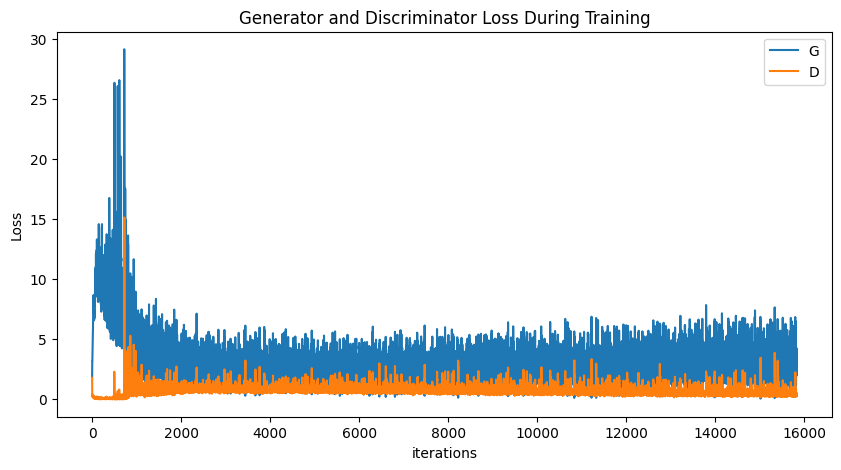

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Generator and Discriminator Loss During Training')
plt.plot(G_losses, label='G')
plt.plot(D_losses, label='D')
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis('off')

ims = [[plt.imshow(np.transpose(img_list[2*index-1], (1,2,0)), animated=True)] for index in range(len(img_list) // 2)]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

In [ ]:
new_noise = torch.randn(30, dim_latent_vector, 1, 1, device=device)
new_generated_imgs = generator(new_noise)
predict = discriminator(new_generated_imgs).view(-1)
print(predict)

tensor([0.2642, 0.1223, 0.4776, 0.1909, 0.0550, 0.0603, 0.1216, 0.5169, 0.1435,
        0.0244, 0.2643, 0.3488, 0.3219, 0.1722, 0.3609, 0.1774, 0.3664, 0.3777,
        0.3898, 0.2176, 0.6645, 0.1163, 0.1239, 0.3235, 0.2876, 0.1411, 0.3113,
        0.1538, 0.1236, 0.0409], device='cuda:0', grad_fn=<ViewBackward0>)
